## 訓練類神經網路

In [79]:
import numpy as np

def softmax_function(x):
    return np.exp(x) / np.sum(np.exp(x))

def sigmoid_function(x):
    return 1/ (1 + np.exp(-x))

def dfunc(f, x):
    h = 1e-4 
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'])
    while not it.finished:     
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        it.iternext()   
    return grad

def cross_entropy_err(y_hat, y):
    delta = 1e-8
    return -np.sum(y*np.log(y_hat + delta))


class ANN:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid_function(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax_function(a2)
        return y
        
    def loss(self, x, y):
        y_hat = self.predict(x)
        return cross_entropy_err(y_hat, y)
        
    def numerical_gradient(self, x, y):
        loss_W = lambda W: self.loss(x, y)
        grads = {}
        grads['W1'] = dfunc(loss_W, self.params['W1'])
        grads['b1'] = dfunc(loss_W, self.params['b1'])
        grads['W2'] = dfunc(loss_W, self.params['W2'])
        grads['b2'] = dfunc(loss_W, self.params['b2'])
        return grads

In [80]:
net = ANN(input_size=4, hidden_size=5, output_size=3)

In [81]:
from sklearn.datasets import load_iris
iris = load_iris()
x    = iris.data

In [82]:
y = np.zeros((len(iris.target), 3))
print(y.shape)
for idx, val in enumerate(iris.target):
    y[idx, val] = 1

(150, 3)


In [83]:
epochs = 3000
lr     = 0.01
train_loss = []

for i in range(epochs):
    grad = net.numerical_gradient(x,y)
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] = net.params[key] - lr * grad[key]
    loss = net.loss(x, y)
    train_loss.append(loss)

Text(0.5,1,'Training Loss')

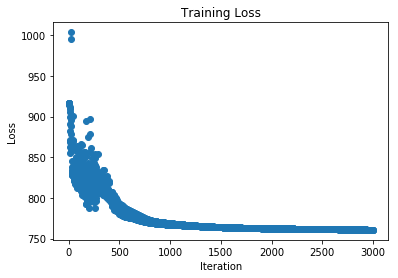

In [84]:
import matplotlib.pyplot as plt

plt.scatter(range(0,3000),train_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')

## 隨機梯度下降

In [85]:
x.shape[0]

150

In [86]:
def cross_entropy_err(y_hat, y):
    y = y.reshape(1, y.size)
    y_hat = y_hat.reshape(1, y_hat.size)
    batch_size = y_hat.shape[0]
    return -np.sum(y * np.log(y_hat)) / batch_size

In [88]:
from numpy import random
net = ANN(input_size=4, hidden_size=5, output_size=3)
epochs = 3000
lr     = 0.01
batch_size = 30
train_loss = []
t0 = time.clock()
for i in range(epochs):
    idx = random.choice(iris.data.shape[0], batch_size)
    x_batch = iris.data[idx]
    y_batch = y[idx]
    grad = net.numerical_gradient(x_batch,y_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] = net.params[key] - lr * grad[key]
    loss = net.loss(x_batch, y_batch)
    train_loss.append(loss)
time.clock() - t0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


9.7613750419996

In [89]:
from numpy import random
random.choice(42,6)

array([ 5, 33, 14, 17,  8, 24])

Text(0.5,1,'Training Loss')

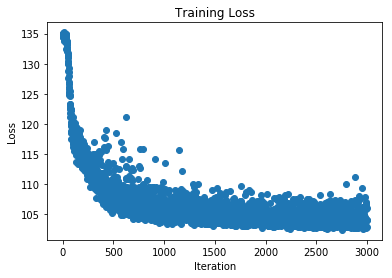

In [90]:
import matplotlib.pyplot as plt

plt.scatter(range(0,3000),train_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')

In [91]:
predicted = np.argmax(net.predict(x), axis = 1)

In [92]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(iris.target, predicted)

0.9666666666666667

In [93]:
confusion_matrix(iris.target, predicted)

array([[50,  0,  0],
       [ 0, 45,  5],
       [ 0,  0, 50]], dtype=int64)

## 反向傳遞

In [94]:
class Relu:
    def __init__(self):
        self.cache = None
    
    def forward(self, x):
        self.cache = (x <=0)
        out = np.maximum(0,x)
        return out

    def backward(self, dout):
        dout[self.cache] = 0
        dx = dout
        return dx

In [119]:
a = Relu()
print(a.cache)

None


In [120]:
x = np.array([-1,1,2])
print(a.forward(x))

[0 1 2]


In [121]:
print(a.cache)

[ True False False]


In [122]:
y = np.array([2,3,4])
y[a.cache] = 0
y

array([0, 3, 4])

In [98]:
y = np.array([2,3,4])
print(a.backward(y))

[0 3 4]


In [99]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1/ (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        y  = self.out
        dx = dout * y * (1-y)
        return dx

In [100]:
s = Sigmoid()
print(s.out)

x = np.array([-1,1,2])
print(s.forward(x))
print(s.out)

None
[0.26894142 0.73105858 0.88079708]
[0.26894142 0.73105858 0.88079708]


In [101]:
y = np.array([2,3,4])
print(s.backward(y))

[0.39322387 0.5898358  0.41997434]


In [102]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout)
        return dx

In [103]:
x = np.array([5,8])
W = np.array([[0.1,0.2,0.3], [0.4,0.5,0.6]])
b = np.array([0.1,0.1,0.1])
a  = Affine(W, b)
print(a.x)
print(a.forward(x))
print(a.x)

None
[3.8 5.1 6.4]
[5 8]


In [104]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y_hat = None 
        self.y = None 

    def forward(self, x, y):
        self.y = y
        self.y_hat = softmax_function(x)
        self.loss = cross_entropy_err(self.y_hat, self.y)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.y.shape[0]
        dx = (self.y_hat - self.y) / batch_size
        return dx

In [105]:
def softmax_function(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

In [106]:
def cross_entropy_err(y_hat, y):
    y      = y.reshape(1, y.size)
    y_hat  = y_hat.reshape(1, y_hat.size)
    batch_size = y_hat.shape[0]
    return -np.sum(y * np.log(y_hat)) / batch_size

In [107]:
import numpy as np
from collections import OrderedDict

class ANN:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid1'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    def loss(self, x, y):
        y_hat = self.predict(x)
        return self.lastLayer.forward(y_hat, y)
  
    def gradient(self, x, y):
        # forward
        self.loss(x, y)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [108]:
from sklearn.datasets import load_iris
iris = load_iris()
x = iris.data
y = np.zeros((len(iris.target), 3))
for idx, val in enumerate(iris.target):
    y[idx, val] = 1

In [109]:
import random
import time

epochs     = 3000
lr         = 0.01
batch_size = 30

net = ANN(input_size=4, hidden_size=5, output_size=3)

t0 = time.clock()
train_loss = []
for i in range(epochs): 
    idx = np.random.choice(iris.data.shape[0], batch_size)
    x_batch   = iris.data[idx]
    y_batch   = y[idx]
    grad = net.gradient(x_batch,y_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] -= lr * grad[key]
    loss = net.loss(x_batch, y_batch)
    train_loss.append(loss)
    
time.clock() - t0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


0.5476205209997715

In [112]:
x = np.array([-1,1,2])
idx = x < 0 

In [113]:
idx

array([ True, False, False])

In [114]:
e = np.array([2,3,4])

In [117]:
e[idx] = 0

In [118]:
e

array([0, 3, 4])

## 手寫數字辨識

In [123]:
from sklearn.datasets import load_digits
digits = load_digits()

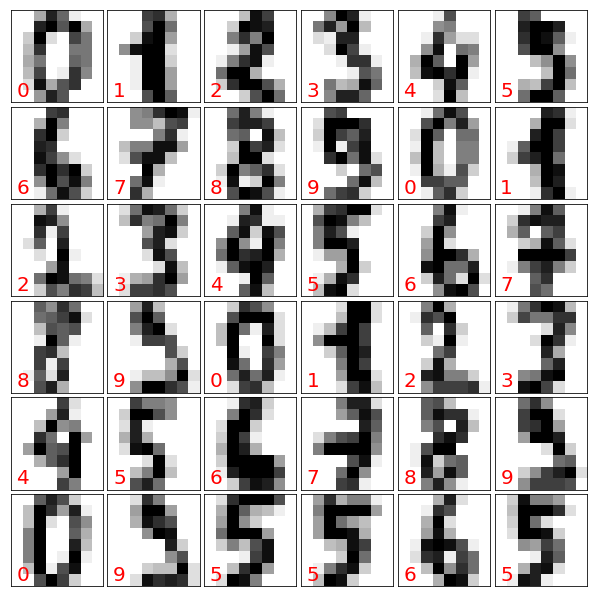

In [124]:
fig = plt.figure(figsize = (8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(36):
    ax = fig.add_subplot(6, 6, i+1, xticks=[], yticks=[])
    ax.imshow(digits.images[i],cmap=plt.cm.binary,interpolation='nearest')
    
    ax.text(0, 7, str(digits.target[i]), color="red", fontsize = 20)


In [127]:
digits.data.shape

(1797, 64)

In [134]:
digits.data[0].reshape(8,8)

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [136]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(digits.data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [137]:
X_scaled = scaler.transform(digits.data)

In [140]:
X_scaled.shape

(1797, 64)

In [142]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [144]:
X_scaled[0]

array([ 0.        , -0.33501649, -0.04308102,  0.27407152, -0.66447751,
       -0.84412939, -0.40972392, -0.12502292, -0.05907756, -0.62400926,
        0.4829745 ,  0.75962245, -0.05842586,  1.12772113,  0.87958306,
       -0.13043338, -0.04462507,  0.11144272,  0.89588044, -0.86066632,
       -1.14964846,  0.51547187,  1.90596347, -0.11422184, -0.03337973,
        0.48648928,  0.46988512, -1.49990136, -1.61406277,  0.07639777,
        1.54181413, -0.04723238,  0.        ,  0.76465553,  0.05263019,
       -1.44763006, -1.73666443,  0.04361588,  1.43955804,  0.        ,
       -0.06134367,  0.8105536 ,  0.63011714, -1.12245711, -1.06623158,
        0.66096475,  0.81845076, -0.08874162, -0.03543326,  0.74211893,
        1.15065212, -0.86867056,  0.11012973,  0.53761116, -0.75743581,
       -0.20978513, -0.02359646, -0.29908135,  0.08671869,  0.20829258,
       -0.36677122, -1.14664746, -0.5056698 , -0.19600752])

In [154]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30), activation='relu'
        , max_iter = 1000, solver='sgd' ,learning_rate='constant',
        learning_rate_init=0.001)

In [155]:
mlp.fit(X_scaled,digits.target)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [156]:
predicted = mlp.predict(X_scaled)

In [157]:
predicted

array([0, 1, 2, ..., 8, 9, 8])

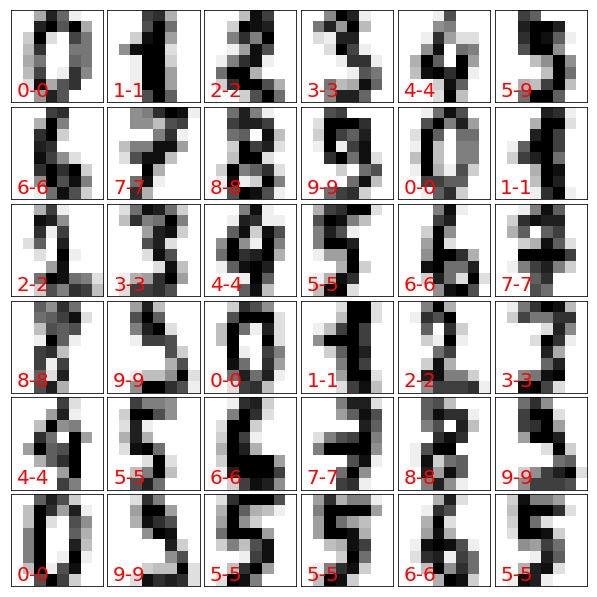

In [158]:
fig = plt.figure(figsize = (8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(36):
    ax = fig.add_subplot(6, 6, i+1, xticks=[], yticks=[])
    ax.imshow(digits.images[i],cmap=plt.cm.binary,interpolation='nearest')
    ax.text(0, 7, str('{}-{}'.format(digits.target[i],predicted[i])), color="red", fontsize = 20)


In [159]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, predicted)

0.996661101836394

In [193]:
from PIL import Image
Image.open('4.png')

In [242]:
from PIL import Image
img = Image.open('4.png').convert('L')

In [243]:
imgarr = np.array(img)

In [244]:
(((255 - imgarr) / 255) * 16).astype(int)

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  0,  9,  0,  0],
       [ 0,  0, 16,  0,  0, 16,  0,  0],
       [ 0, 12, 14,  0,  0, 16,  0,  0],
       [ 0, 14, 16, 16, 16, 16, 11,  0],
       [ 0,  0,  0,  0,  0, 16,  0,  0],
       [ 0,  0,  0,  0,  0, 16,  0,  0],
       [ 0,  0,  0,  0,  0, 13,  0,  0]])

In [245]:
img2 = (((255 - imgarr) / 255) * 16).astype(int)

In [246]:
img2.shape

(8, 8)

In [247]:
img2

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  0,  9,  0,  0],
       [ 0,  0, 16,  0,  0, 16,  0,  0],
       [ 0, 12, 14,  0,  0, 16,  0,  0],
       [ 0, 14, 16, 16, 16, 16, 11,  0],
       [ 0,  0,  0,  0,  0, 16,  0,  0],
       [ 0,  0,  0,  0,  0, 16,  0,  0],
       [ 0,  0,  0,  0,  0, 13,  0,  0]])

In [248]:
img3 = img2.reshape(64).reshape(1, -1)

In [249]:
img3.shape

(1, 64)

In [250]:
digits.data[4].reshape(8,8)

array([[ 0.,  0.,  0.,  1., 11.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  7.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  1., 13.,  6.,  2.,  2.,  0.],
       [ 0.,  0.,  7., 15.,  0.,  9.,  8.,  0.],
       [ 0.,  5., 16., 10.,  0., 16.,  6.,  0.],
       [ 0.,  4., 15., 16., 13., 16.,  1.,  0.],
       [ 0.,  0.,  0.,  3., 15., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  2., 16.,  4.,  0.,  0.]])

In [251]:
img3[0].reshape(8,8)

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  0,  9,  0,  0],
       [ 0,  0, 16,  0,  0, 16,  0,  0],
       [ 0, 12, 14,  0,  0, 16,  0,  0],
       [ 0, 14, 16, 16, 16, 16, 11,  0],
       [ 0,  0,  0,  0,  0, 16,  0,  0],
       [ 0,  0,  0,  0,  0, 16,  0,  0],
       [ 0,  0,  0,  0,  0, 13,  0,  0]])

In [252]:
P_scaled = scaler.transform(img3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [253]:
mlp.predict(P_scaled)

array([4])